In [1]:
import yaml
from pathlib import Path
from typing import List, Annotated, TypedDict, Dict, Any, Literal

# LangGraph imports
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Tool imports
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.tools import BaseTool

from langgraph.checkpoint.postgres.aio import AsyncPostgresSaver
from psycopg_pool import AsyncConnectionPool
from app.core.langgraph.tools import tools
from app.core.config import settings, Environment

max_size = settings.POSTGRES_POOL_SIZE


async def get_conection_pool() -> AsyncConnectionPool:
    
    connection_pool = AsyncConnectionPool(
                        settings.POSTGRES_URL,
                        open=True,
                        max_size=max_size,
                        kwargs={
                            "autocommit": True,
                            "connect_timeout": 5,
                            "prepare_threshold": None,
                        }
                    )
    await connection_pool.open()
    return connection_pool

connection_pool = await get_conection_pool()

checkpoint = AsyncPostgresSaver(connection_pool) if connection_pool else None

==== Auto Agent
----- 0.2


d:\anaconda\envs\adv_pyth\Lib\site-packages\psycopg_pool\pool_async.py:142: RuntimeWarning: opening the async pool AsyncConnectionPool in the constructor is deprecated and will not be supported anymore in a future release. Please use `await pool.open()`, or use the pool as context manager using: `async with AsyncConnectionPool(...) as pool: `...
  warnings.warn(


In [2]:
checkpoint

In [3]:
LLM_INSTANCE = ChatOpenAI(model="gpt-4.1", temperature=0)

# Example tool instance
# In your LangGraphAgent, you have `self.tools_by_name`. This map should be used.
DUCKDUCKGO_SEARCH_TOOL = DuckDuckGoSearchResults(num_results=3, name="DuckDuckGoSearch") # Explicitly name it for clarity
AVAILABLE_TOOLS_MAP: Dict[str, BaseTool] = {
    DUCKDUCKGO_SEARCH_TOOL.name: DUCKDUCKGO_SEARCH_TOOL,
    # Add other tools your agents might use, e.g.:
    # "another_tool": AnotherToolInstance(),
}

In [4]:
def load_yaml_config(config_file_path: str) -> Dict[str, Any]:
    """Loads YAML configuration from the given file path."""
    path = Path(config_file_path)
    if not path.is_absolute():
        # This assumes the script is run from a location where this relative path makes sense
        # Or, ideally, make config_file_path always absolute or relative to a known project root.
        # For example, if your config is in 'project_root/app/config/graph_config.yaml':
        # path = (Path(__file__).parent.parent.parent / "app/config" / config_file_path).resolve()
        # Adjust this path resolution based on your project structure.
        # For this example, we'll assume config_file_path is correctly specified.
        pass
    
    with open(path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)

In [5]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel

class AgentResponse(BaseModel):
    next: Literal["FINISH", "supervisor"]
    content: str

parser = PydanticOutputParser(pydantic_object=AgentResponse)
format_instructions = parser.get_format_instructions()
format_instructions

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"next": {"enum": ["FINISH", "supervisor"], "title": "Next", "type": "string"}, "content": {"title": "Content", "type": "string"}}, "required": ["next", "content"]}\n```'

In [6]:


def create_agent_runnable_from_md_file(
    md_file: Path,
    agent_llm: ChatOpenAI,
    agent_tools: List[BaseTool]
) -> Any:
    """
    Creates a LangGraph agent runnable using create_react_agent.
    The agent's system message is read from the provided .md file.
    """
    with open(md_file, "r", encoding="utf-8") as f:
        system_message_content = f.read()
    # get file name from path and remove extension
    
    system_message_name = md_file.stem  # This gives you the file name without the extension
    


    # create_react_agent uses the provided content as the core system message.
    # It internally uses a prompt template (often from LangChain Hub) 
    # that incorporates this system message, tools, and messages.
    return create_react_agent(
        model=agent_llm,
        tools=agent_tools,
        prompt=system_message_content, # This is the key part from your .md file
        name=system_message_name,
        checkpointer=checkpoint
    )

In [7]:
def build_supervised_graph_from_config(
    graph_name: str, # For logging and identification
    graph_specific_config: Dict[str, Any],
    shared_llm_instance: ChatOpenAI,
    tool_name_to_instance_map: Dict[str, BaseTool],
    project_root_dir: Path # To resolve relative paths in YAML robustly
) -> StateGraph:
    """
    Builds a supervised LangGraph (subgraph) based on the provided configuration.
    The configuration specifies a directory containing:
    - 'system.md': For the supervisor's system prompt.
    - Other '*.md': For individual agent system prompts.
    """
    # Resolve the path to the prompts directory for this subgraph
    # The path in YAML (graph_specific_config["path"]) is relative to project_root_dir
    prompts_relative_path = graph_specific_config["path"]
    prompts_base_dir = (project_root_dir / prompts_relative_path).resolve()

    if not prompts_base_dir.is_dir():
        raise FileNotFoundError(f"Prompt directory not found for graph '{graph_name}': {prompts_base_dir}")

    supervisor_prompt_file = prompts_base_dir / "system.md"
    print(f"[INFO] Graph '{graph_name}': Looking for supervisor prompt in {supervisor_prompt_file}")
    if not supervisor_prompt_file.exists():
        raise FileNotFoundError(f"Supervisor 'system.md' not found in {prompts_base_dir} for graph '{graph_name}'")

    with open(supervisor_prompt_file, "r", encoding="utf-8") as f:
        supervisor_system_prompt = f.read()
        supervisor_system_prompt = supervisor_system_prompt.replace("{format_instructions}", format_instructions)


    # Find all .md files for agents (excluding system.md)
    agent_md_files = [f for f in prompts_base_dir.glob("*.md") if f.name.lower() != "system.md"]
    print(f"[INFO] Graph '{graph_name}': Found {len(agent_md_files)} agent .md files in {prompts_base_dir}")
    if not agent_md_files:
        raise ValueError(f"No agent .md files found in {prompts_base_dir} for graph '{graph_name}' (expected files like 'agent_name.md')")

    agent_names = [md_file.stem for md_file in agent_md_files] # e.g., "expense_analyst" from "expense_analyst.md"
    
    # Resolve tools for agents based on graph_specific_config or defaults
    # For simplicity, this example assumes all agents in this subgraph use the same set of tools.
    # You could extend YAML to specify tools per agent if needed.
    tool_names_for_subgraph = graph_specific_config.get("default_tools", [])
    subgraph_agent_tools: List[BaseTool] = []
    for tool_name in tool_names_for_subgraph:
        if tool_name in tool_name_to_instance_map:
            subgraph_agent_tools.append(tool_name_to_instance_map[tool_name])
        else:
            print(f"[WARNING] For graph '{graph_name}', tool '{tool_name}' not found in available tools map. Skipping.")


    # 1. Create agent runnables
    agent_runnables: Dict[str, Any] = {}
    for md_file, agent_name in zip(agent_md_files, agent_names):
        runnable = create_agent_runnable_from_md_file(
            md_file,
            shared_llm_instance, # Agents use the same LLM instance
            tools  # Agents use the resolved tools
        )
        agent_runnables[agent_name] = runnable
        print(f"[INFO] Graph '{graph_name}': Created agent runnable '{agent_name}' from '{md_file.name}'")

    # 2. Create the supervisor runnable
    supervisor_runnable = create_supervisor(
        agents=[agent for agent in agent_runnables.values()],
        model=shared_llm_instance,
        prompt=supervisor_system_prompt,
        tools=tools
        
    )

    app = supervisor_runnable.compile(checkpointer=checkpoint)
    # # 3. Build the StateGraph
    # workflow = StateGraph(SupervisedSubgraphState)

    # # Add the supervisor node
    # workflow.add_node("supervisor", supervisor_runnable)
    # print(f"[INFO] Graph '{graph_name}': Added 'supervisor' node.")

    # # Add agent nodes and edges from agents back to supervisor
    # for agent_name, runnable in agent_runnables.items():
    #     workflow.add_node(agent_name, runnable)
    #     workflow.add_edge(agent_name, "supervisor") # After an agent runs, it returns control to the supervisor
    #     print(f"[INFO] Graph '{graph_name}': Added agent node '{agent_name}' and edge to supervisor.")

    # # Define conditional edges from the supervisor
    # # The supervisor's output (in state['next']) determines where to go next.
    # # This can be one of the agent names or END.
    # conditional_routing_map = {name: name for name in agent_names} # Route to agent_name if state['next'] == agent_name
    # conditional_routing_map[END] = END # Terminate if state['next'] == END
    
    # workflow.add_conditional_edges(
    #     "supervisor",
    #     lambda state: state["next"], # The 'next' field in SupervisedSubgraphState dictates routing
    #     conditional_routing_map
    # )

    # # Set the entry point for the subgraph
    # workflow.set_entry_point("supervisor")
    
    # # Compile the subgraph (no checkpointer needed here, main graph can have one)
    # compiled_subgraph = workflow.compile()
    # print(f"[INFO] Graph '{graph_name}': Compiled successfully.")
    return app

In [8]:
prompts_dir = r"D:\Shiva\agent-zero-lite\iChatGPT\app\core\prompts\finance\analysis"

In [9]:
# import os
# with open(os.path.join(prompts_dir, "system.md"), "w", encoding="utf-8") as f:
#     f.write(
#         "You are a supervisor managing a team of financial analysts. "
#         "Your team members are: expense_analyst and ratio_analyst.\n"
#         "Based on the user's requesst and the conversation history, decide which analyst should handle the task next, "
#         "Use the available tools to assist the analysts in their tasks.\n"
#         "or if the task is complete, respond with FINISH.\n"
#     )

In [10]:
test_yaml_file_path = r"D:\Shiva\agent-zero-lite\iChatGPT\app\config\graph_config.yaml"
loaded_config = load_yaml_config(test_yaml_file_path)

In [11]:
loaded_config

{'graphs': {'finance_analysis': {'path': 'app/core/prompts/finance/analysis',
   'nodes': [{'name': 'controller', 'file': 'controller.md', 'tools': None},
    {'name': 'expense_analyst', 'file': 'expense_analyst.md'},
    {'name': 'ratio_analyst', 'file': 'ratio_analyst.md'}],
   'edges': [{'from': 'controller', 'to': 'expense_analyst'}]}}}

In [12]:
compiled_grph = build_supervised_graph_from_config(
    graph_name="finance_analysis",
    graph_specific_config=loaded_config["graphs"]["finance_analysis"],
    shared_llm_instance=LLM_INSTANCE,
    tool_name_to_instance_map=AVAILABLE_TOOLS_MAP,
    project_root_dir=Path(r"D:\Shiva\agent-zero-lite\iChatGPT")
)

[INFO] Graph 'finance_analysis': Looking for supervisor prompt in D:\Shiva\agent-zero-lite\iChatGPT\app\core\prompts\finance\analysis\system.md
[INFO] Graph 'finance_analysis': Found 3 agent .md files in D:\Shiva\agent-zero-lite\iChatGPT\app\core\prompts\finance\analysis
[INFO] Graph 'finance_analysis': Created agent runnable 'controller' from 'controller.md'
[INFO] Graph 'finance_analysis': Created agent runnable 'expense_analyst' from 'expense_analyst.md'
[INFO] Graph 'finance_analysis': Created agent runnable 'ratio_analyst' from 'ratio_analyst.md'


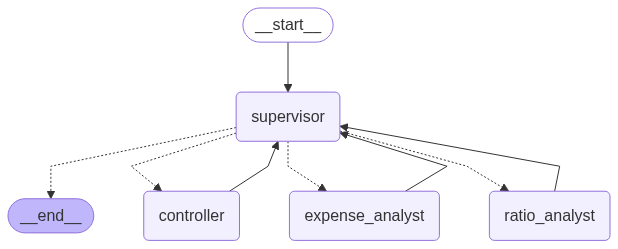

In [13]:

compiled_grph

In [14]:
initial_user_query = HumanMessage(
    content="Create a ratio analysis of Zomato and save it in a CSV file in the /mnt/data folder"
    "Also, analyze the expenses of Zomato and provide insights on cost-saving opportunities."
)

# The initial state for the subgraph. The supervisor will receive these messages.
initial_subgraph_state = {"messages": [initial_user_query]}


compiled_grph.invoke(initial_subgraph_state)

ValueError: Checkpointer requires one or more of the following 'configurable' keys: ['thread_id', 'checkpoint_ns', 'checkpoint_id']

### Make Supervisor Node using langgraph function

In [15]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel
from app.schemas import GraphState
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


# class State(MessagesState):
#     next: str


# def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
#     options = ["FINISH"] + members
#     system_prompt = (
#         "You are a supervisor tasked with managing a conversation between the"
#         f" following workers: {members}. Given the following user request,"
#         " respond with the worker to act next. Each worker will perform a"
#         " UNderstand and analyze the response from the agents, respond with next as FINISH if the task seems accomplished as per the previous nodes message."
#         " task and respond with their results and status. When finished,"
#         " respond with next as FINISH."
#     )

#     class Router(TypedDict):
#         """Worker to route to next. If no workers needed, route to FINISH."""

#         next: Literal[*options]

#     def supervisor_node(state: GraphState) -> Command[Literal[*members, "__end__"]]:
#         """An LLM-based router."""
#         messages = [
#             {"role": "system", "content": system_prompt},
#         ] + state.messages
#         print("The supervisor node messages are:", messages)
#         response = llm.with_structured_output(Router).invoke(messages)
#         print("The supervisor node response is:", response)
#         goto = response["next"]
#         if goto == "FINISH":
#             goto = END

#         return Command(goto=goto, update={"next": goto})

#     return supervisor_node


# from typing import TypedDict, Literal
# from langgraph.graph import END, GraphState, Command
# from langchain_core.messages import AIMessage

def make_supervisor_node(llm: BaseChatModel, members: list[str]):
    options = ["FINISH"] + members
    system_prompt = (
        "## Supervisor Agent\n\n"
        "You are a high-agency supervisor overseeing a team of workers: "
        f"{members}. Your job is to **analyze progress**, **plan**, and **delegate work** to these workers."
        "\n\n"
        "### Goals:\n"
        "0. Think and plan — outline the next logical step(s).\n"
        "1. Reflect on what’s already been done and what remains.\n"
        "2. Break the overall goal into clear subtasks.\n"
        "3. Decide who (among the available workers) is best suited to take the next step.\n"
        "4. You can use each worker as a tool to complete subtasks.\n"
        "5. Stop only when the task is fully completed and all outputs have been verified.\n\n"
        "### Rules:\n"
        "- Use high-agency reasoning. Do not just forward work randomly.\n"
        "- You must create and share a plan in the form of bullet-point thoughts.\n"
        "- Always respond in **structured JSON** format.\n"
        "- If the task is complete, respond with `FINISH`.\n"
        "- Only one worker can be selected at a time.\n"
        "- Prefer clear delegation based on subtask alignment.\n\n"
        "### Output Format:\n"
        "{\n"
        '  "thoughts": ["Thought 1", "Thought 2", "..."],\n'
        '  "next": "suggested next worker or FINISH"\n'
        "}"
    )


    class Router(TypedDict):
        thoughts: list[str]
        next: Literal[*options]

    def supervisor_node(state: GraphState) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based planning supervisor node."""
        messages = [{"role": "system", "content": system_prompt}] + state.messages

        print("The supervisor node messages are:", messages)

        response = llm.with_structured_output(Router).invoke(messages)

        print("The supervisor node response is:", response)

        goto = response["next"]
        if goto == "FINISH":
            goto = END

        # Create a formatted message from the response
        ai_message = AIMessage(
            content=f"Thoughts:\n" + "\n".join(f"- {t}" for t in response["thoughts"]) +
                    f"\n\nNext: {response['next']}",
            name="supervisor"
        )

        return Command(
            goto=goto,
            update={
                "next": goto,
                "thoughts": response["thoughts"],
                "messages": [ai_message]
            }
        )

    return supervisor_node


In [16]:
from langchain_core.messages import BaseMessage
from app.schemas import GraphState
llm = ChatOpenAI(model="gpt-4o")

# teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [17]:
import json
from app.schemas import GraphState
from langchain_core.messages import ToolMessage
from app.core.langgraph.graph import LangGraphAgent
from langgraph.types import Command
from typing_extensions import TypedDict

def call_finance_team(state: GraphState) -> Command[Literal["supervisor"]]:
    print(f"Calling finance team with state: {state}")
    response = compiled_grph.invoke({"messages": state.messages})

    print(f"Response from finance team: {response}")
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="finance_team"
                )
            ]
        },
        goto="supervisor",
    )


# def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
#     response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
#     return Command(
#         update={
#             "messages": [
#                 HumanMessage(
#                     content=response["messages"][-1].content, name="writing_team"
#                 )
#             ]
#         },
#         goto="supervisor",
#     )

{"environment": "development", "log_level": "DEBUG", "log_format": "CONSOLE", "event": "logging_initialized", "logger": "app.core.logging", "level": "info", "timestamp": "2025-06-10T17:27:15.317289Z", "lineno": 180, "pathname": "d:\\Shiva\\agent-zero-lite\\iChatGPT\\app\\core\\logging.py", "func_name": "<module>", "filename": "logging.py", "module": "logging"}


In [18]:
from langchain_core.messages import BaseMessage
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4.1")

teams_supervisor_node = make_supervisor_node(llm, ["finance_team", "response"])

In [19]:
response_agent = LangGraphAgent()

def make_response_node(members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    # class Router(TypedDict):
    #     """Worker to route to next. If no workers needed, route to FINISH."""

    #     next: Literal[*options]

    async def response_node(state: GraphState) -> Command[Literal[*members]]:
        """An LLM-based router."""
        # messages = [
        #     {"role": "system", "content": system_prompt},
        # ] + state["messages"]
        # response = llm.with_structured_output(Router).invoke(messages)
        full_history = state.messages[:]
        print("Entered Response Node", full_history)
        sup_resp = await response_agent.get_response(
            messages=full_history,
            session_id=state.session_id,
            user_id=state.user_id if hasattr(state, "user_id") else "unknown",
        )
        print("The response node response is:", sup_resp)
        raw_json = sup_resp[-1]
        # parsed = json.loads(raw_json)
        if isinstance(raw_json, ToolMessage):
            text_tool = raw_json.content
            return Command(
                goto="supervisor",
                update={"messages": [AIMessage(content=text_tool, name="response")]}
            )




        # next_agent = raw_json.next
        task_text  = raw_json.content

        # if next_agent == "FINISH":
        #     next_agent = END

        # goto = response["next"]
        # if goto == "FINISH":
        #     goto = END

        # return Command(goto=next_agent, update={"next": goto})
        # Route to finance by sending a HumanMessage(name="finance", content=task_text)
        return Command(
            goto="supervisor",
            update={"messages": [AIMessage(content=task_text, name="response")]}
        )

        # return Command(goto=goto, update={"next": goto})

    return response_node


response_node = make_response_node(["supervisor"])

Tools available: dict_keys(['code_execution_tool'])
{"model": "gpt-4o-mini", "environment": "development", "event": "llm_initialized", "logger": "app.core.logging", "level": "info", "timestamp": "2025-06-10T17:27:41.719724Z", "lineno": 96, "pathname": "d:\\Shiva\\agent-zero-lite\\iChatGPT\\app\\core\\langgraph\\graph.py", "func_name": "__init__", "filename": "graph.py", "module": "graph"}


Starting new HTTPS connection (1): mermaid.ink:443
https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCXN1cGVydmlzb3Ioc3VwZXJ2aXNvcikKCWZpbmFuY2VfdGVhbShmaW5hbmNlX3RlYW0pCglyZXNwb25zZShyZXNwb25zZSkKCV9fZW5kX18oWzxwPl9fZW5kX188L3A+XSk6OjpsYXN0CglfX3N0YXJ0X18gLS0+IHN1cGVydmlzb3I7CglmaW5hbmNlX3RlYW0gLS4tPiBzdXBlcnZpc29yOwoJcmVzcG9uc2UgLS4tPiBzdXBlcnZpc29yOwoJc3VwZXJ2aXNvciAtLi0+IF9fZW5kX187CglzdXBlcnZpc29yIC0uLT4gZmluYW5jZV90ZWFtOwoJc3VwZXJ2aXNvciAtLi0+IHJlc3BvbnNlOwoJY2xhc3NEZWYgZGVmYXVsdCBmaWxsOiNmMmYwZmYsbGluZS1oZWlnaHQ6MS4yCgljbGFzc0RlZiBmaXJzdCBmaWxsLW9wYWNpdHk6MAoJY2xhc3NEZWYgbGFzdCBmaWxsOiNiZmI2ZmMK?type=png&bgColor=!white HTTP/1.1" 200 14466


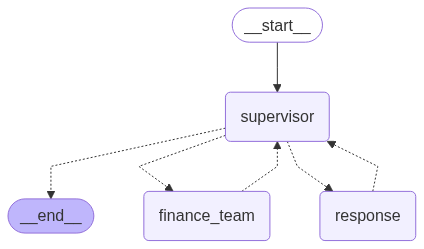

In [20]:
super_builder = StateGraph(GraphState)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("finance_team", call_finance_team)
super_builder.add_node("response", response_node)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile(checkpointer=checkpoint)

super_graph

In [21]:
# research_builder = StateGraph(GraphState)
# research_builder.add_node("supervisor", supervisor_node)
# research_builder.add_node("finance", call_finance_team)

# research_builder.add_edge(START, "supervisor")
# research_graph = research_builder.compile()

# research_graph

In [ ]:
from langchain_core.messages import HumanMessage
from app.schemas import Message

content = json.dumps({"text": "Analyze the financial health of Reliance Industries using recent news.", "next": "supervisor"})
# msg = HumanMessage(content=content)

messages = [
    # HumanMessage(content="Read the content of the file bse_stock_data.csv in the mnt/data folder in the root directory. Perform a ratio analysis of the data and save the results in a CSV file in the mnt/data folder."),
    # HumanMessage(content="Get the file with the data about cricket players from /mnt/data folder in the root directory and tell me names of all the players in the file."),
    HumanMessage(content="Who has the least runs amongst these players?"),
    # Message(role="user", content="Who has the least runs amongst these players?", next="supervisor")
]

import asyncio


# async def main():
#     result = await research_graph.get_response(
#         messages,
#         session_id="session_subgraph_12351",  # Any unique session ID
#         user_id="user1"
#     )
#     print("=== Final Response ===")
#     for msg in result:
#         print(msg["type"].upper() + ": " + msg["content"])

# asyncio.run(main())

# research_graph.ainvoke({"messages": messages, "session_id": "shiva_subgraph_1234", "user_id": "user1234"})
config = {
        "configurable": {
            "thread_id": "shiva_subgraph_1289"
        }
    }
response = await super_graph.ainvoke({
    "messages": messages,
    "session_id": "shiva_subgraph_1289",
    "user_id": "user1234"
}, config=config)

The supervisor node messages are: [{'role': 'system', 'content': '## Supervisor Agent\n\nYou are a high-agency supervisor overseeing a team of workers: [\'finance_team\', \'response\']. Your job is to **analyze progress**, **plan**, and **delegate work** to these workers.\n\n### Goals:\n0. Think and plan — outline the next logical step(s).\n1. Reflect on what’s already been done and what remains.\n2. Break the overall goal into clear subtasks.\n3. Decide who (among the available workers) is best suited to take the next step.\n4. You can use each worker as a tool to complete subtasks.\n5. Stop only when the task is fully completed and all outputs have been verified.\n\n### Rules:\n- Use high-agency reasoning. Do not just forward work randomly.\n- You must create and share a plan in the form of bullet-point thoughts.\n- Always respond in **structured JSON** format.\n- If the task is complete, respond with `FINISH`.\n- Only one worker can be selected at a time.\n- Prefer clear delegation 

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

receive_response_headers.complete return_value=(b'HTTP/1.1', 207, b'Multi-Status', [(b'Date', b'Tue, 10 Jun 2025 18:00:43 GMT'), (b'Content-Type', b'application/json; charset=utf-8'), (b'Content-Length', b'263'), (b'Connection', b'keep-alive'), (b'Cf-Ray', b'94dac5149e744421-BOM'), (b'X-Robots-Tag', b'noindex'), (b'X-Content-Type-Options', b'nosniff'), (b'Referrer-Policy', b'strict-origin-when-cross-origin'), (b'Document-Policy', b'js-profiling'), (b'Permissions-Policy', b'autoplay=*, fullscreen=*, microphone=*'), (b'X-Frame-Options', b'SAMEORIGIN'), (b'Vary', b'Origin, Accept-Encoding'), (b'Etag', b'"tdh95as3cl7b"'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Report-To', b'{"endpoints":[{"url":"https:\\/\\/a.nel.cloudflare.com\\/report\\/v4?s=8Fk10Bsiq09Zq%2BuCXTWvk50inad0UdEjEI0JHb1GYS5fns28WNUaGlyHafASPO%2BvQmpCmTATGboxS67y6nCOM4X2red9jzOUcVoy1eynaTU4Wq03bv%2Bjhou%2BJMArN3okqIIt%2FQ5KLQ%3D%3D"}],"group":"cf-nel","max_age":604800}'), (b'Nel', b'{"success_fraction":0,"report_to":"cf-nel","m

send_request_headers.started request=<Request [b'POST']>
send_request_headers.complete
send_request_body.started request=<Request [b'POST']>
send_request_body.complete
receive_response_headers.started request=<Request [b'POST']>
receive_response_headers.complete return_value=(b'HTTP/1.1', 207, b'Multi-Status', [(b'Date', b'Tue, 10 Jun 2025 18:00:44 GMT'), (b'Content-Type', b'application/json; charset=utf-8'), (b'Content-Length', b'145'), (b'Connection', b'keep-alive'), (b'Cf-Ray', b'94dac51b7cf54421-BOM'), (b'X-Robots-Tag', b'noindex'), (b'X-Content-Type-Options', b'nosniff'), (b'Referrer-Policy', b'strict-origin-when-cross-origin'), (b'Document-Policy', b'js-profiling'), (b'Permissions-Policy', b'autoplay=*, fullscreen=*, microphone=*'), (b'X-Frame-Options', b'SAMEORIGIN'), (b'Vary', b'Origin, Accept-Encoding'), (b'Etag', b'"mbp676kjh41"'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Report-To', b'{"endpoints":[{"url":"https:\\/\\/a.nel.cloudflare.com\\/report\\/v4?s=nBAWZt1hPkP2APIjNAn41r4r

In [26]:
response 

{'messages': [HumanMessage(content='Get the file with the data about cricket players from /mnt/data folder in the root directory and tell me names of all the players in the file.', additional_kwargs={}, response_metadata={}, id='b9c96482-e461-4173-ba0a-76c6f68bc5c2'),
  AIMessage(content="Thoughts:\n- The user wants to extract and list the names of all cricket players from a file located at '/mnt/data' in the root directory.\n- The first step is to identify and access the file with cricket player data in the specified folder.\n- Once the file is identified, read its contents to extract the names of the players.\n\nNext: finance_team", additional_kwargs={}, response_metadata={}, name='supervisor', id='5e20498f-7553-4114-8136-afe5b7d58a6a'),
  HumanMessage(content='The file contains the following player names:\n\n- Sachin Tendulkar\n- MS Dhoni\n- Rohit Sharma\n- Jasprit Bumrah\n\nIf you need more details or want information about their statistics, let me know!', additional_kwargs={}, res

In [ ]:
main_graph

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
main_graph = await agent.create_graph(subgraph_node=compiled_grph)

In [ ]:
# main_graph

from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

# main_graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)

main_graph.get_graph().print_ascii()